# Air Quality Analysis Model

This project conducts an analysis of air quality using linear classification and regression techniques to Carbon Monoxide (CO) values.



## 1. Dataset and Knowledge Preparation

The dataset contains measurements of air quality from a multisensor device. The device used spectrometer analyzers (variables marked by "GT") and solid state metal oxide detectors (variables marked by "PT08.Sx"), as well as temperature (T), relative humidity (RH) and absolute humidity (AH) sensors. 

The dataset contains instances of hourly averaged measurements taken at road level in a polluted city. The task is to predict the CO(GT) variable representing carbon monoxide levels. There are missing features in this dataset, flagged by the number `-999`. 

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import sklearn.model_selection

notebook_start_time = time.time()

# Import data - it should be saved in the same root directory as this notebook
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(5)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
1527,2.3,1116.250000,14.336906,1127.500000,153.0,739.000000,129.0,1855.50,1042.00,34.850000,24.850000,1.362996
1872,1.6,1206.500000,7.724488,887.750000,202.5,610.750000,99.2,1382.25,1042.00,25.700000,35.725000,1.162616
2638,2.5,1145.750000,13.002522,1083.750000,159.0,712.750000,121.0,1829.25,1215.00,27.300000,35.275001,1.260579
1582,5.5,1402.333333,26.299078,1461.666667,867.3,449.333333,222.5,1599.00,1885.00,4.066667,47.933333,0.395871
1841,3.2,1274.250000,16.553254,1196.500000,192.0,625.750000,120.0,2023.00,1356.25,24.650001,47.075000,1.439951


## 2. Linear Classification via Gradient Descent

The air quality is assessed using the CO(GT) variable. If it is no greater than 4.5, the air quality is good (CO(GT)<=4.5), otherwise, it is bad (CO(GT)>4.5). The task is to perform binary classification to predict whether the air quality is good based on the other 11 varivables, i.e., from PT08.S1(CO) to AH. 

### 2.1 Model Training and Testing

This practice is about training a binary linear classifier by minimising a hinge loss with L2 (ridge) regularisation, and then testing its performance. Given a set of $N$ training samples $\{(\mathbf{x}_i, y_i)\}_{i=1}^N$, where $\mathbf{x}_i$ is the feature vector and $y_i \in \{-1, +1\}$ is the class label for the $i$-th training sample, the training objective function to minimise is 
$$O = C \sum^N_{i=1}\max\left(0, 1 - y_i \left(\mathbf{w}^T\mathbf{x}_i + w_0\right)\right) + \frac{1}{2}\mathbf{w}^T\mathbf{w}. $$
Here, $\mathbf{w}$ is a column weight vector of the linear model, $w_0$ is the bias parameter of the model, and $C$ is the regularisation hyperparameter.

The function returns the trained model weights, the corresponding objective function value (referred to as cost) and the accuracy per iteration. In addition to the training data, the function takes the regularisation hyperparameter $C$, learning rate $\eta$, and the number of iterations $N_{max}$ as arguments. A default setting of these parameters has been provided below, which is able to provide reasonably good performance.  

In [5]:
def linear_gd_train(data, labels, c=0.2, n_iters=200, learning_rate=0.001, random_state=None # Add any other arguments here if needed
          ):
    """
    Trains a linear model using gradient descent.

    data: training data
    labels: training labels (boolean)
    c: regularisation parameter
    n_iters: number of iterations
    learning_rate: learning rate for gradient descent

    Returns an array of cost and model weights per iteration.
    """
    # Set random seed for reproducibility if using random initialisation of weights (optional)
    rng = np.random.default_rng(seed=random_state)

    # Create design matrix and labels
    X_tilde = np.hstack((np.ones((data.shape[0], 1)), data))
    y = 2 * labels.astype(int) - 1

    # Weight initialisation: use e.g. rng.standard_normal() or all zeros
    w = rng.standard_normal(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.ones((n_iters, w.shape[0]))
    cost_all = np.ones(n_iters)
    acc_all = np.ones(n_iters)
    
    # GD update of weights
    for i in range(n_iters):
        # Cost and gradient update of the linear model
        predictions = X_tilde @ w # predict the labels using the current model
        error = 1 - y * predictions # how far off the prediction is from the true label
        hinge_losses = np.maximum(0, error) # create an array of hinge losses
        cost = c * np.sum(hinge_losses) + 0.5 * np.sum(w[1:] ** 2) # multiply the hinge losses by the regularisation parameter and add the regularisation term
        
        condition = error > 0 # if the error is greater than 0, the prediction is incorrect
        # Compute the gradient of the cost function
        # only misclassified points contribute to the gradient
        # the gradient of the regularisation term is the weights themselves (do not regularise the bias term)
        hinge_losses_grad = -c * X_tilde.T @ (condition * y) + np.append([0], w[1:]) 
        
        # Weight update
        w = w - learning_rate * hinge_losses_grad
        
        # save w, cost and accuracy of each iteration in w_all, cost_all and acc_all
        w_all[i] = w
        cost_all[i] = cost
        acc_all[i] = np.mean((predictions > 0) == labels)

    # Return model parameters.
    return cost_all, w_all, acc_all


def linear_predict(data, w):
    """
    Predicts the labels using the trained weights.

    data: test data
    w: model weights

    Returns the predicted labels.
    """

    X_tilde = np.hstack((np.ones((data.shape[0], 1)), data))
    y_pred = X_tilde @ w

    return y_pred

The code below splits the data into training and testing sets and imputes the missing features. 

In [6]:
from sklearn.impute import SimpleImputer

# Put a threshold on the labels to cast to binary: True if CO(GT) > 4.5, False otherwise
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

# Named _cls to keep our classification experiments distinct from regression
train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15, stratify=binary_targets)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()

train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

Now, train the model, plot the training objective function value and the classification accuracy of the training set over iterations, and print the classification accuracy and $F_1$ score of the testing set.

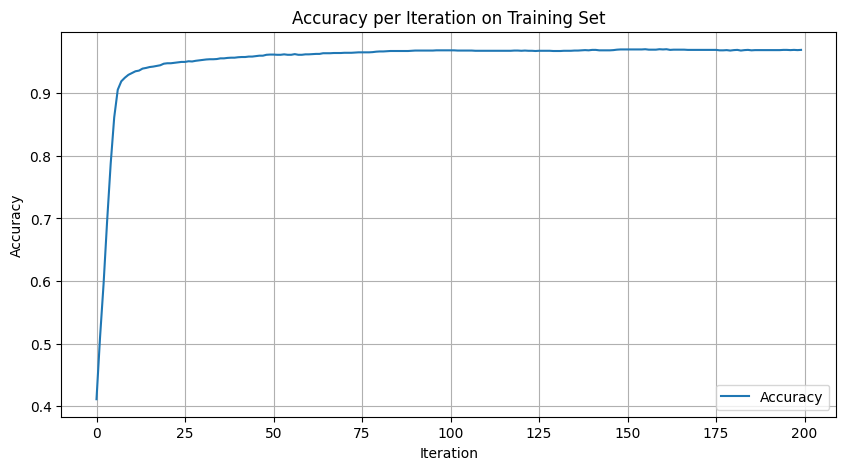

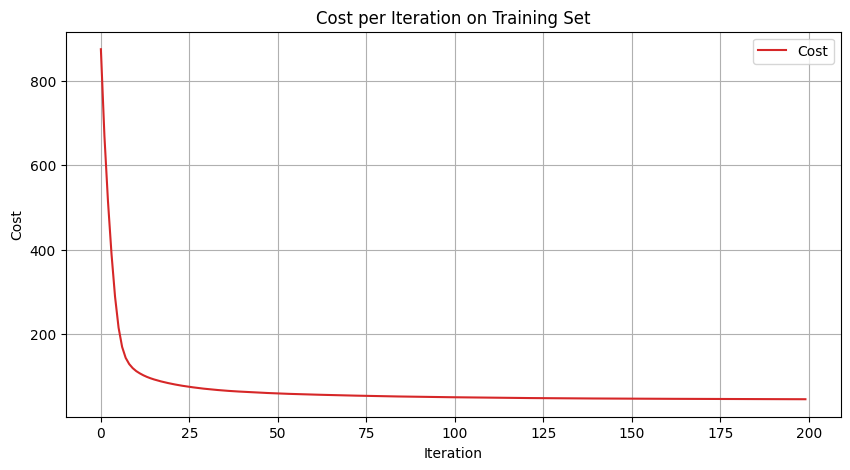

Accuracy on test set: 0.97379
F1 score on test set: 0.77966
Precision on test set: 0.92000
Recall on test set: 0.67647


In [7]:
# Train the model
costs, w, acc = linear_gd_train(train_X_cls, train_y_cls, random_state=42)

# Plot accuracy and cost per iteration on training set
plt.figure(figsize=(10, 5))
plt.plot(acc, label='Accuracy', color='tab:blue')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy per Iteration on Training Set')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(costs, label='Cost', color='tab:red')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost per Iteration on Training Set')
plt.legend()
plt.grid(True)
plt.show()

# Apply imputation to the test set
test_X_cls = imputer.transform(test_X_cls)
test_X_cls = scaler.transform(test_X_cls)

# Predict on test set, report accuracy and f1 score
y_pred = linear_predict(test_X_cls, w[-1])
y_pred_acc = np.mean((y_pred > 0) == test_y_cls)
print(f'Accuracy on test set: {y_pred_acc:.5f}')

precision = np.sum((y_pred > 0) & test_y_cls) / np.sum((y_pred > 0).astype(int))
recall = np.sum((y_pred > 0) & test_y_cls) / np.sum(test_y_cls)
f1 = (2 * precision * recall) / (precision + recall)
print(f'F1 score on test set: {f1:.5f}')
print(f'Precision on test set: {precision:.5f}')
print(f'Recall on test set: {recall:.5f}')

### 2.2 Learning Rate Analysis

The learning rate $\eta$ (Greek letter "eta") is a key parameter that affects the model training and performance. The below experiment aims to demonstrate the effect of $\eta$ on model training, and on the model performance during testing.

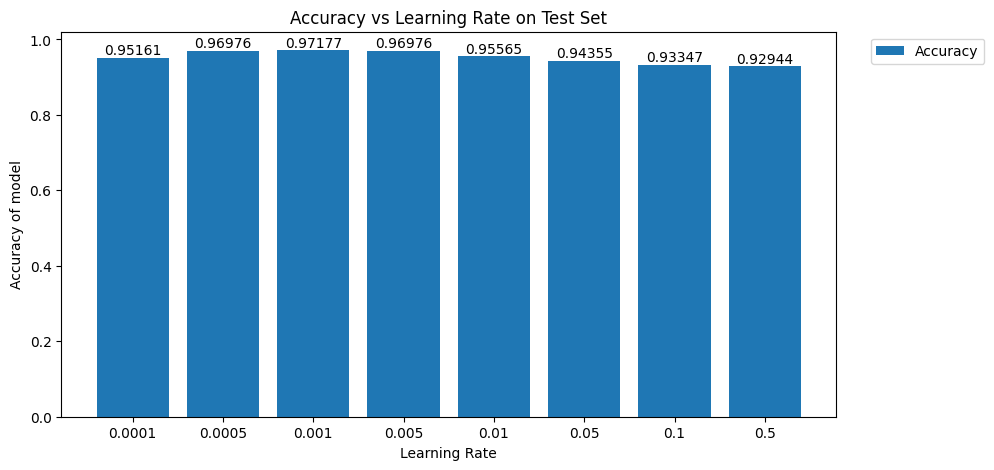

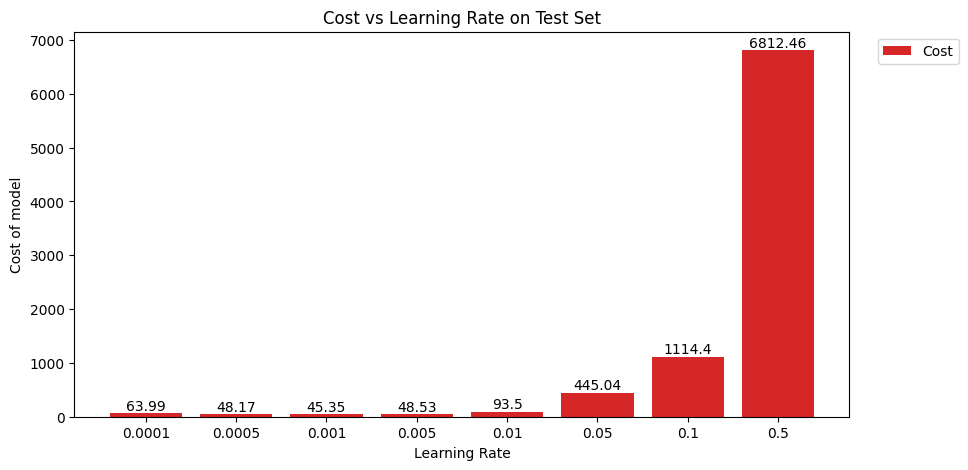

In [8]:
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
x = range(len(learning_rates))
lr_acc = []
lr_costs = []
for lr in learning_rates:
    costs, w, acc = linear_gd_train(train_X_cls, train_y_cls, learning_rate=lr, random_state=123)
    y_pred = linear_predict(test_X_cls, w[-1])
    y_pred_acc = np.mean((y_pred > 0) == test_y_cls)
    lr_acc.append(y_pred_acc)
    lr_costs.append(costs[-1])

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(lr_acc)), lr_acc, color='tab:blue', label='Accuracy')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 5), ha='center', va='bottom')

plt.xlabel('Learning Rate')
plt.xticks(x, learning_rates)
plt.ylabel('Accuracy of model')
plt.title('Accuracy vs Learning Rate on Test Set')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(lr_costs)), lr_costs, color='tab:red', label='Cost')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.xlabel('Learning Rate')
plt.xticks(x, learning_rates)
plt.ylabel('Cost of model')
plt.title('Cost vs Learning Rate on Test Set')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()



## 3. Air Quality Analysis by Neural Network

In this experiment, we will predict the CO(GT) value based on the other 11 variables through regression. For this purpose we will use a neural network to build a nonlinear regression model.


### 3.1 Simple MLP Model Selection

This section is focused on the practical aspects of MLP implementation and model selection. We will first compare some model architectures. 

The set of MLP architectures to select is specified in `param_grid` below, including two MLPs with one hidden layer, where one has a small number of 3 hidden neurons, while the other has a larger number of 100 hidden neurons, and two MLPs with two hidden layers, where one is small (3, 3) and the other is larger (100, 100). It also includes two activation function options, i.e., the logistic and the rectified linear unit ("relu").  These result in a total of 8 model options, where sklearn default parameters are used for all the MLPs and their training. 

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {   
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

Now, we should do the following: Split the dataset into the training and testing sets. Preprocess the data by imputing the missing features. Use the training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. We can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation of the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.  


In [10]:
# Redo split for regression
binary_targets = (sensor_data_full['CO(GT)']).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

train_X_cls, test_X_cls, train_y_cls, test_y_cls = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15)

# Impute missing values and standardise the data
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()


# Prepare the data
train_X_cls = imputer.fit_transform(train_X_cls)
train_X_cls = scaler.fit_transform(train_X_cls)

# Define MLP model
regr = MLPRegressor(random_state=123, max_iter=1000)

# Initialise and fit the grid search
grid_search = GridSearchCV(regr, param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
grid_search.fit(train_X_cls, train_y_cls)

# Report the best parameters and the CV results
best_params = grid_search.best_params_
print("Best Parameters for regression are:", best_params)
print(grid_search.cv_results_)

# Report model performance
regr = MLPRegressor(random_state=123, max_iter=1000, **best_params)
regr.fit(train_X_cls, train_y_cls)

# Prepare the test set
test_X_cls = imputer.transform(test_X_cls)
test_X_cls = scaler.transform(test_X_cls)

print(f'Testing set R^2: {regr.score(test_X_cls, test_y_cls):.5f}')
print(f'Testing set MSE: {np.mean((regr.predict(test_X_cls) - test_y_cls) ** 2):.5f}')


Best Parameters for regression are: {'activation': 'relu', 'hidden_layer_sizes': (100, 100)}
{'mean_fit_time': array([0.4524179 , 1.07126241, 0.89013662, 2.89602847, 0.68165631,
       1.10973721, 1.09809656, 2.16449847]), 'std_fit_time': array([0.05489881, 0.12664481, 0.17355437, 0.36787391, 0.03058589,
       0.20024409, 0.03563861, 0.92252848]), 'mean_score_time': array([0.00042958, 0.00057173, 0.00039172, 0.00066504, 0.00046096,
       0.00097456, 0.00049844, 0.00187159]), 'std_score_time': array([6.12562986e-05, 7.02097985e-05, 9.10996112e-06, 1.72115097e-05,
       1.71153629e-04, 1.78196796e-05, 1.86794382e-04, 4.54912096e-04]), 'param_activation': masked_array(data=['relu', 'relu', 'relu', 'relu', 'logistic', 'logistic',
                   'logistic', 'logistic'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=np.str_('?'),
            dtype=object), 'param_hidden_layer_sizes': masked_array(data=[(3,), (100,), (3, 3), (100, 100), (

### 3.2 Training Algorithm Comparison: SGD and ADAM

In this exercise, we will compare two training algorithms, stochastic gradient descent (SGD) and ADAM optimisation, for training an MLP with two hidden layers each containing 100 neurons with "relu" activation, under the settings specified in `test_params` as below.

In [11]:
test_params = [
    {
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'solver': 'adam'
    },{
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'learning_rate': 'adaptive', 
        'momentum': 0.95, 
        'solver': 'sgd'
    },
]

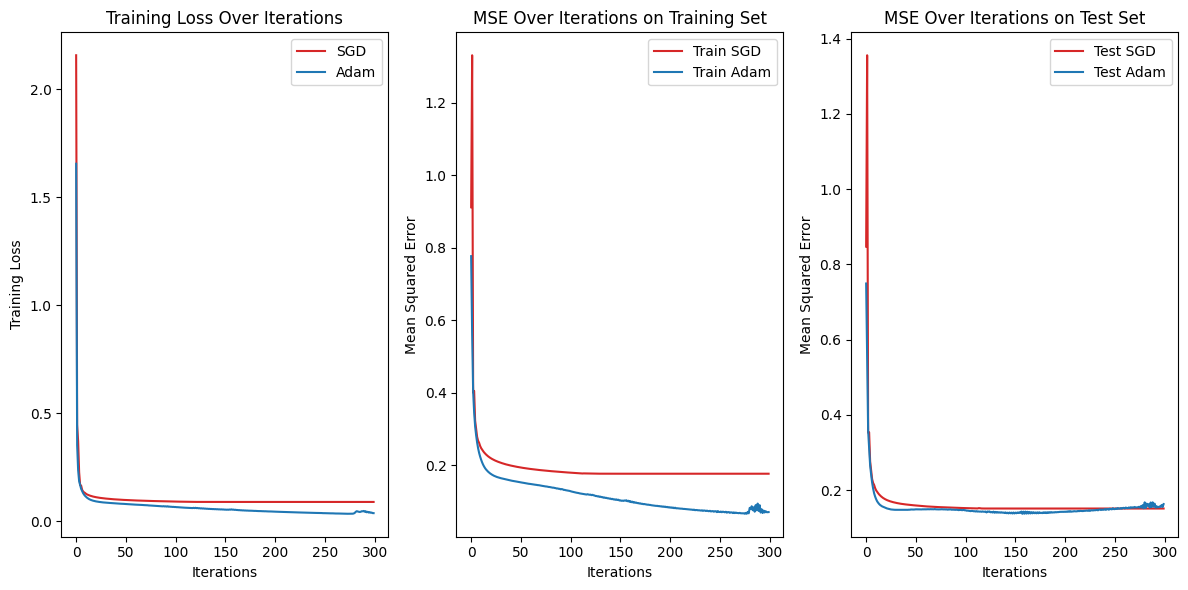

Testing set R^2 for Adam: 0.91761
Testing set MSE for Adam: 0.16297
Testing set R^2 for SGD: 0.92360
Testing set MSE for SGD: 0.15111


In [12]:
# Train models and plot learning curves
regr_adam = MLPRegressor(random_state=123, max_iter=300, **test_params[0])
regr_sgd = MLPRegressor(random_state=123, max_iter=300, **test_params[1])

regr_adam_loss = []
regr_sgd_loss = []

train_mse_adam = []
train_mse_sgd = []

test_mse_adam = []
test_mse_sgd = []

for i in range(300):

    # Fitting the models to partial data to simulate learning curves
    regr_adam.partial_fit(train_X_cls, train_y_cls)
    regr_sgd.partial_fit(train_X_cls, train_y_cls)

    # Save the loss for each model
    regr_adam_loss.append(regr_adam.loss_)
    regr_sgd_loss.append(regr_sgd.loss_)

    # Calculate training MSE for each model
    train_mse_adam.append(np.mean((regr_adam.predict(train_X_cls) - train_y_cls) ** 2))
    train_mse_sgd.append(np.mean((regr_sgd.predict(train_X_cls) - train_y_cls) ** 2))

    # Calculate testing MSE for each model
    test_mse_adam.append(np.mean((regr_adam.predict(test_X_cls) - test_y_cls) ** 2))
    test_mse_sgd.append(np.mean((regr_sgd.predict(test_X_cls) - test_y_cls) ** 2))

# Plot learning curves
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(regr_sgd_loss, label='SGD', color='tab:red')
plt.plot(regr_adam_loss, label='Adam', color='tab:blue')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Iterations')
plt.legend()

# Plot MSE for training sets
plt.subplot(1, 3, 2)
plt.plot(train_mse_sgd, label='Train SGD', color='tab:red')
plt.plot(train_mse_adam, label='Train Adam', color='tab:blue')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Iterations on Training Set')
plt.legend()

# Plot MSE for testing sets
plt.subplot(1, 3, 3)
plt.plot(test_mse_sgd, label='Test SGD', color='tab:red')
plt.plot(test_mse_adam, label='Test Adam', color='tab:blue')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Iterations on Test Set')
plt.legend()
plt.tight_layout()
plt.show()

# Print final test set performance for both models
print(f'Testing set R^2 for Adam: {regr_adam.score(test_X_cls, test_y_cls):.5f}')
print(f'Testing set MSE for Adam: {np.mean((regr_adam.predict(test_X_cls) - test_y_cls) ** 2):.5f}')

print(f'Testing set R^2 for SGD: {regr_sgd.score(test_X_cls, test_y_cls):.5f}')
print(f'Testing set MSE for SGD: {np.mean((regr_sgd.predict(test_X_cls) - test_y_cls) ** 2):.5f}')


The air quality analysis project aimed to predict CO values using linear classification and regression with scikit-learn. 

In the linear classification section, we used a logistic regression model to classify air quality data into two categories based on a threshold. We trained the model using gradient descent and evaluated its performance on a test set. The model achieved an accuracy of around 97% and an F1 score of 0.78 on the test set, indicating its effectiveness in classifying air quality.

In the regression section, we used a multilayer perceptron (MLP) regression model to predict CO values based on other variables. We performed model selection using grid search and cross-validation, and selected the best model based on mean squared error (MSE). The selected model had a hidden neuron layer size of (100, 100) and was using the ReLu activation function. It achieved a good performance on the test set, with an R^2 score of around 0.92 and an MSE of around 0.17.

Finally we compared two training algorithms; stochastic gradient descent and Adam using the selected model parameters from the previous section. We found that Adam performed better in terms of convergence speed and final performance.

Overall, the project demonstrated the effectiveness of linear classification and regression techniques in predicting CO values in air quality analysis. These models can be valuable tools for understanding and monitoring air pollution levels, which is crucial for public health and environmental management.